## Imports

In [1]:
# import kagglehub
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as T
import random
import optuna
from optuna.trial import TrialState

In [2]:
# path = kagglehub.dataset_download("sidharkal/sports-image-classification")

# print("Path to dataset files:", path)

In [2]:
data_dir = "../data"
images_dir = "../data/dataset/"
train_dir = images_dir + "train/"

badminton_train_dir = train_dir + "Badminton/"
tennis_train_dir = train_dir + "Tennis/"
cricket_train_dir = train_dir + "Cricket/"
soccer_train_dir = train_dir + "Soccer/"
swimming_train_dir = train_dir + "Swimming/"
karate_train_dir = train_dir + "Karate/"
wrestling_train_dir = train_dir + "Wrestling/"

test_dir = images_dir + "test/"

badminton_test_dir = test_dir + "Badminton/"
tennis_test_dir = test_dir + "Tennis/"
cricket_test_dir = test_dir + "Cricket/"
soccer_test_dir = test_dir + "Soccer/"
swimming_test_dir = test_dir + "Swimming/"
karate_test_dir = test_dir + "Karate/"
wrestling_test_dir = test_dir + "Wrestling/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.manual_seed(42)

In [ ]:
# shutil.copytree(path, data_dir, dirs_exist_ok=True)

## Organizing Data structure

In [4]:
# checking the train.csv , test.csv
train_df = pd.read_csv(images_dir +"/train.csv")
test_df = pd.read_csv(images_dir +"/test.csv")

In [5]:
test_df

,image_ID
0,f5e13966e7.jpg
1,6674191b4e.jpg
2,91b5f8b7a9.jpg
3,393119b6d6.jpg
4,1ce5f81578.jpg
...,...
2051,7be6c552a7.jpg
2052,4c9427f2a5.jpg
2053,0f429ae0d4.jpg
2054,a6557bedd9.jpg


In [6]:
train_df

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket
...,...,...
8222,903d2fffb3.jpg,Cricket
8223,b5f174c688.jpg,Badminton
8224,2433770a67.jpg,Tennis
8225,6403964166.jpg,Tennis


In [7]:
train_df.set_index("image_ID", inplace=True), test_df.set_index("image_ID", inplace=True)

(None, None)

### Moving data to be per label

In [8]:
labels = train_df["label"].unique()

for label in labels:
    os.makedirs(train_dir + label, exist_ok=True)
    os.makedirs(test_dir + label, exist_ok=True)

In [9]:
labels

array(['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer',
       'Wrestling', 'Karate'], dtype=object)

In [10]:
train_df.loc['7c225f7b61.jpg']['label']

'Badminton'

In [11]:
print(train_dir)

../data/dataset/train/


In [12]:
for i in range(len(train_df)):
    image_id = train_df.index[i]
    label = train_df['label'][i]
    old_path = train_dir + image_id
    new_path = train_dir + label + "/" + image_id
    if os.path.exists(old_path):
        shutil.move(old_path, new_path)

### Labeling Test data as it was unlabeled

In [13]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

classes = ['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer', 'Wrestling', 'Karate']

def classify_with_clip(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=classes, images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image 
    probs = logits_per_image.softmax(dim=1)
    pred = probs.argmax()
    return classes[pred]

KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(len(test_df))):
    image_id = test_df.index[i]
    image_path = test_dir + image_id
    if not os.path.exists(image_path):
        continue
    label = classify_with_clip(image_path)
    test_df.at[image_id, 'label'] = label
    new_path = test_dir + label + "/" + image_id
    if os.path.exists(image_path):
        shutil.move(image_path, new_path)


## Statistics from the data

### Checking distribution of classes

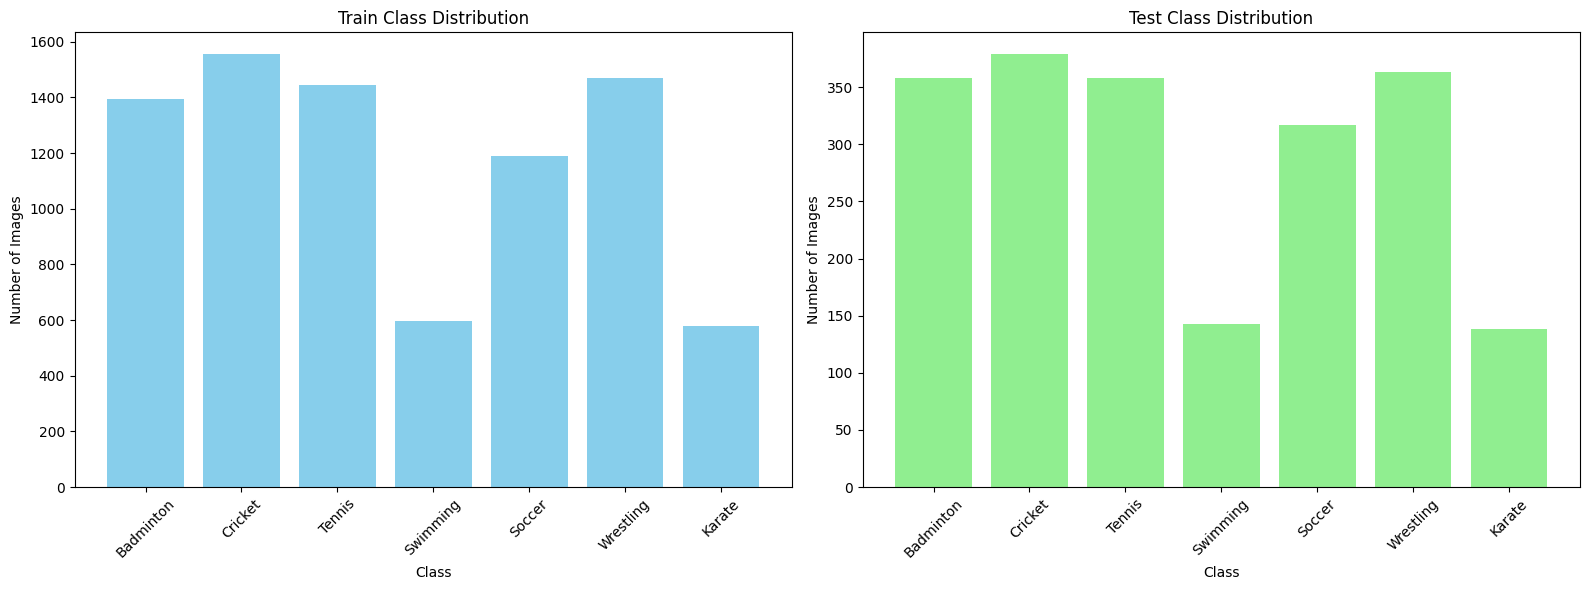

In [14]:

classes = ['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer', 'Wrestling', 'Karate']

train_dirs = [train_dir + cls + "/" for cls in classes]
test_dirs = [test_dir + cls + "/" for cls in classes]

train_counts = [len(os.listdir(d)) if os.path.exists(d) else 0 for d in train_dirs]
test_counts = [len(os.listdir(d)) if os.path.exists(d) else 0 for d in test_dirs]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].bar(classes, train_counts, color='skyblue')
axs[0].set_title('Train Class Distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of Images')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(classes, test_counts, color='lightgreen')
axs[1].set_title('Test Class Distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Number of Images')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Per class statistics

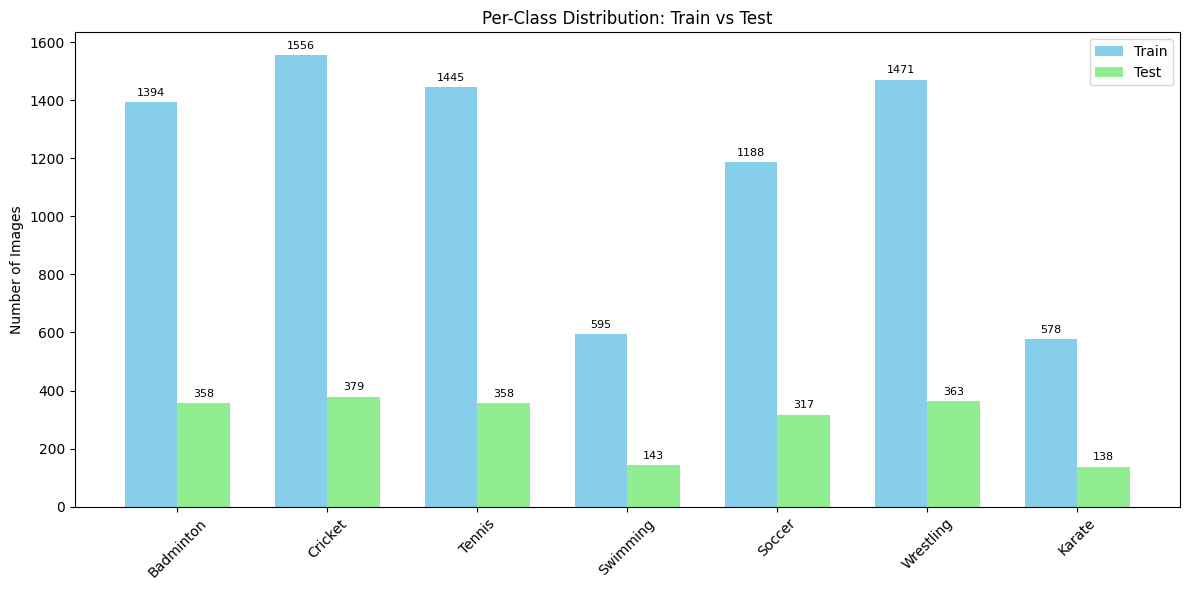

In [15]:
x = np.arange(len(classes))  
width = 0.35  

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train', color='skyblue')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test', color='lightgreen')

ax.set_ylabel('Number of Images')
ax.set_title('Per-Class Distribution: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.legend()

def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

annotate_bars(rects1)
annotate_bars(rects2)

plt.tight_layout()
plt.show()

### Pixel Value Distribution

100%|██████████| 7/7 [00:00<00:00, 62.05it/s]


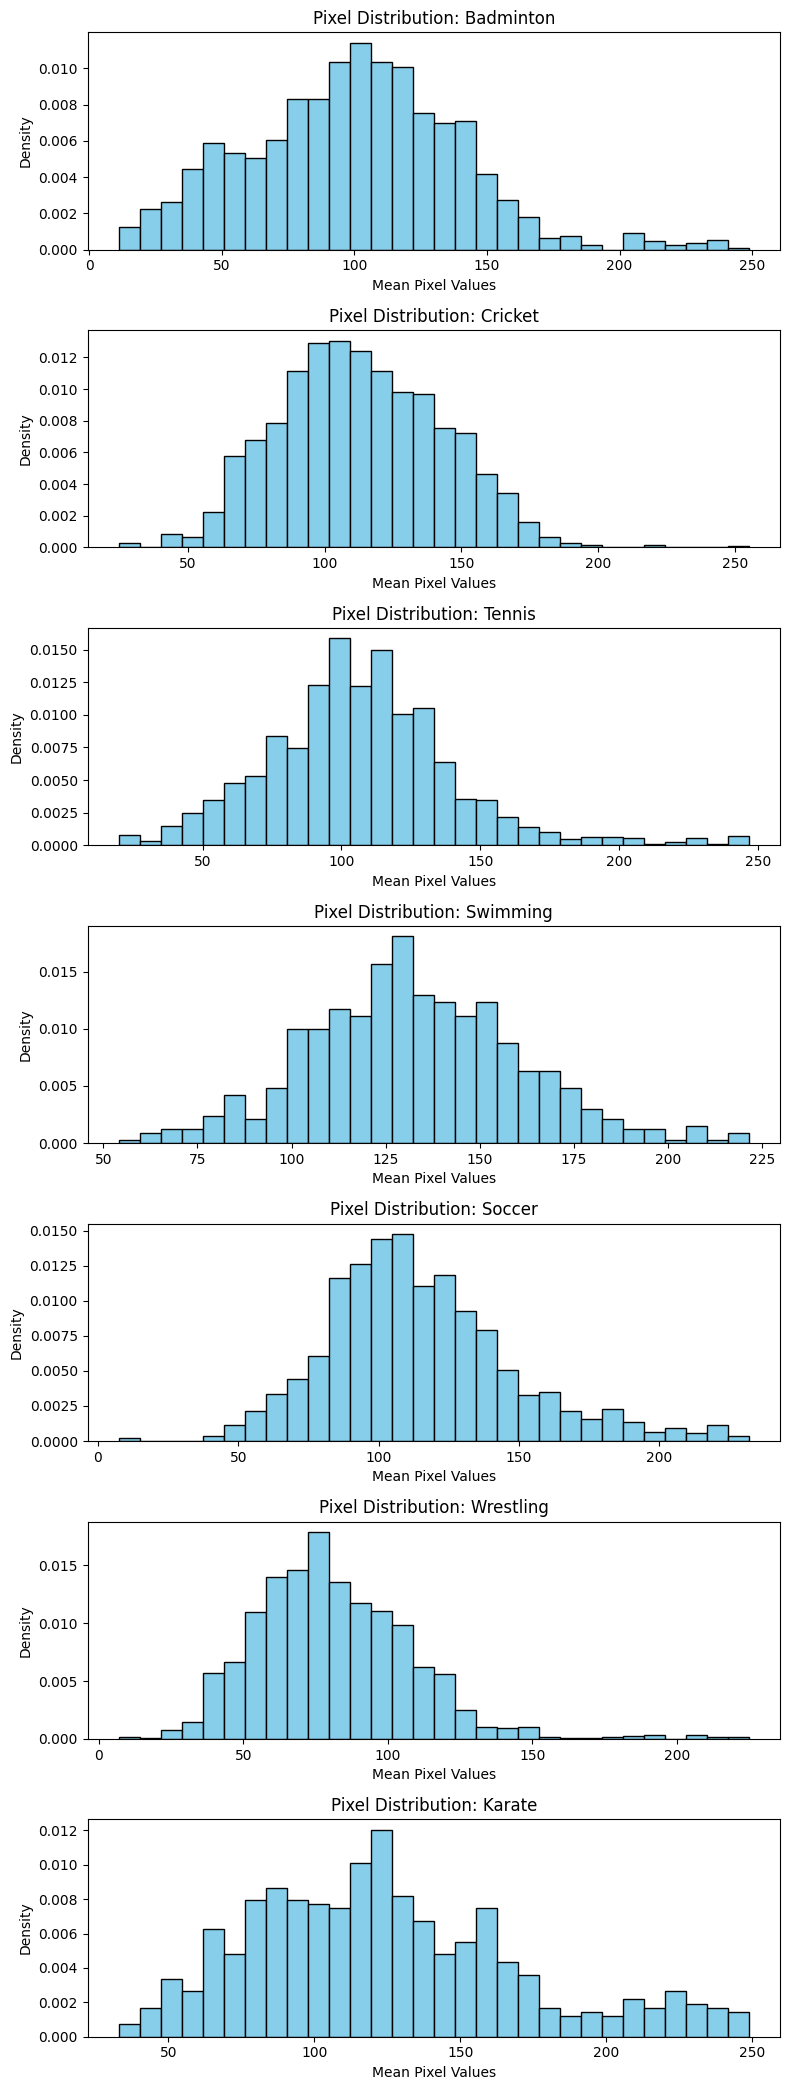

In [16]:
class_brightness = {cls: [] for cls in classes}

for cls, folder in zip(classes, train_dirs):
    if not os.path.exists(folder):
        continue
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        try:
            img = Image.open(img_path).convert("L")  
            img_arr = np.array(img)
            mean_brightness = img_arr.mean()
            class_brightness[cls].append(mean_brightness)
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")

# Plot distributions
fig, axs = plt.subplots(len(classes), 1, figsize=(8, len(classes)*3))

for idx, cls in enumerate(tqdm(classes)):
    axs[idx].hist(class_brightness[cls], bins=30, color='skyblue', edgecolor='black', density=True)
    axs[idx].set_title(f'Pixel Distribution: {cls}')
    axs[idx].set_xlabel('Mean Pixel Values')
    axs[idx].set_ylabel('Density')

plt.tight_layout()
plt.show()

- Pixels values are distributed well across all the images meaning that the images are not too dark or too bright.
- Thus images is considered to be well exposed and not too dark or too bright so little noise are added.

## Showing some images per class

In [ ]:
fig, axs = plt.subplots(len(classes), 2, figsize=(8, len(classes) * 3))

for row_idx, (cls, folder) in enumerate(zip(classes, train_dirs)):
    if not os.path.exists(folder):
        continue
    images = [f for f in os.listdir(folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    selected_images = images[:2]  
    for col_idx in range(2):
        if col_idx < len(selected_images):
            img_path = os.path.join(folder, selected_images[col_idx])
            img = Image.open(img_path)
            axs[row_idx, col_idx].imshow(img)
            axs[row_idx, col_idx].axis('off')
            if col_idx == 0:
                axs[row_idx, col_idx].set_title(f"{cls} - Sample 1")
            else:
                axs[row_idx, col_idx].set_title(f"{cls} - Sample 2")
        else:
            axs[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

## Dataset class and data manager

### Dataset class 1

In [6]:
classes = ['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer', 'Wrestling', 'Karate']

In [7]:
class ImageDataset1(Dataset):
    def __init__(self, root_dir, classes, transform=None, is_train=True):
        """
        Args:
            root_dir (str): Directory with all the class folders
            classes (list): List of class names (subfolder names)
            transform (callable, optional): Optional transform to be applied on a sample
            is_train (bool): Whether this is training data or not
        """
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.is_train = is_train
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.samples = []

        # Default transforms if none provided
        if self.transform is None:
            if is_train:
                self.transform = T.Compose([
                    T.RandomResizedCrop(128), # Resize to 128x128
                    # T.RandomHorizontalFlip(),
                    # T.RandomRotation(15),
                    T.ToTensor(),
                ])
            else:
                self.transform = T.Compose([
                    T.Resize(224),
                    T.CenterCrop(128), # Resize to 128x128
                    T.ToTensor(),
                ])

        for idx, cls in enumerate(classes):
            class_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(class_folder):
                continue
            for img_name in os.listdir(class_folder):
                if img_name.lower().endswith(('jpg', 'jpeg', 'png')):
                    img_path = os.path.join(class_folder, img_name)
                    self.samples.append((img_path, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx, retry=0):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            if retry < 3:
                return self.__getitem__(random.randint(0, len(self)-1), retry=retry+1)
            else:
                raise RuntimeError("Too many failed image loads.")

### Dataset class 2

In [8]:
class ImageDataset2(Dataset):
    def __init__(self, root_dir, classes, transform=None, is_train=True, split_ratio=0.8, seed=42):
        """
        Args:
            root_dir (str): Directory with all the class folders
            classes (list): List of class names (subfolder names)
            transform (callable, optional): Optional transform to be applied on a sample
            is_train (bool): Whether this is training data or not
            split_ratio (float): Ratio for training data (default is 0.8)
            seed (int): Seed for reproducibility
        """
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.is_train = is_train
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.samples = []

        all_samples = []
        for idx, cls in enumerate(classes):
            class_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(class_folder):
                continue
            for img_name in os.listdir(class_folder):
                if img_name.lower().endswith(('jpg', 'jpeg', 'png')):
                    img_path = os.path.join(class_folder, img_name)
                    all_samples.append((img_path, idx))

        # Shuffle and split once
        random.seed(seed)
        random.shuffle(all_samples)
        split_point = int(len(all_samples) * split_ratio)
        if is_train:
            self.samples = all_samples[:split_point]
        else:
            self.samples = all_samples[split_point:]

        # Set default transforms if not provided
        if self.transform is None:
            if is_train:
                self.transform = T.Compose([
                    T.RandomResizedCrop(128),
                    T.ToTensor(),
                ])
            else:
                self.transform = T.Compose([
                    T.Resize(224),
                    T.CenterCrop(128),
                    T.ToTensor(),
                ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx, retry=0):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            if retry < 3:
                return self.__getitem__(random.randint(0, len(self)-1), retry=retry+1)
            else:
                raise RuntimeError("Too many failed image loads.")

In [9]:
classes = ['Badminton', 'Cricket', 'Tennis', 'Swimming', 'Soccer', 'Wrestling', 'Karate']

# Modelling

### Model 1: Simple CNN1

In [10]:
class Simplenet1(nn.Module):
    def __init__(self, num_classes=7):
        super(Simplenet1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # 128 128 3 -> 128 128 64 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 128 128 64 -> 64 64 64
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 64 64 -> 64 64 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 64 64 128 -> 32 32 128
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # 32 32 128 -> 32 32 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 32 32 256 -> 16 16 256
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # 16 16 256 -> 16 16 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 16 16 512 -> 8 8 512
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # 8 8 512 -> 1 1 512
            nn.Flatten(), # 1 1 512 -> 512
            nn.Linear(512, 256), # 512 -> 256
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # Dropout layer
            nn.Linear(256, 128), # 256 -> 128
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # Dropout layer
            nn.Linear(128, num_classes), # 128 -> num_classes
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Model 2: Simple CNN2

In [11]:
class Simplenet2(nn.Module):
    def __init__(self, num_classes=7):
        super(Simplenet2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False), # 128x128x3 → 128x128x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False), # 128x128x64 → 128x128x64
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2), # 128x128x64 → 64x64x64

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False), # 64x64x64 → 64x64x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False), # 64x64x128 → 64x64x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2), # 64x64x128 → 32x32x128

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False), # 32x32x128 → 32x32x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False), # 32x32x256 → 32x32x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2), # 32x32x256 → 16x16x256

            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False), # 16x16x256 → 16x16x512
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False), # 16x16x512 → 16x16x512
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2), # 16x16x512 → 8x8x512

            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False), # 8x8x512 → 8x8x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2) # 8x8x256 → 4x4x256
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                  # 4x4x256 = 4096
            nn.Linear(256 * 4 * 4, 512),   # 4096 → 512
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)   # 512 → num_classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Model 3: Simple CNN3

In [12]:
class SimpleNet3(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleNet3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2), # 128 128 3 -> 63 63 64
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 63 63 64 -> 31 31 64
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # 31 31 64 -> 14 14 128
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #   14 14 128 -> 7 7 128
            nn.Conv2d(32, 64, kernel_size=3, stride=2), # 7 7 128 -> 3 3 256
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(576, 288),
            nn.ReLU(inplace=True),
            nn.Linear(288, 144),
            nn.ReLU(inplace=True),
            nn.Linear(144, 72),
            nn.ReLU(inplace=True),
            nn.Linear(72, 36),
            nn.ReLU(inplace=True),
            nn.Linear(36, 18),
            nn.ReLU(inplace=True),
            nn.Linear(18, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Model 4: Simple CNN4

In [13]:
class SimpleNet4(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleNet4, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 128 128 3 -> 128 128 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # 128 128 32 -> 64 64 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # 64 64 32 -> 64 64 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # 64 64 64 -> 32 32 64
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 32 32 64 -> 16 16 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # 16 16 128 -> 8 8 128
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),#   -> 4 x 4 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Utils for Pretrained

In [14]:
def freeze_all_but_last_n(model, n=2):
    for param in model.parameters():
        param.requires_grad = False

    # Get all modules with parameters
    modules_with_params = [m for m in model.modules() if any(p.requires_grad is False for p in m.parameters())]

    # Unfreeze last n modules with parameters
    for module in modules_with_params[-n:]:
        for param in module.parameters():
            param.requires_grad = True

    return model


def print_trainable_params(model):
    print("Trainable Parameters:")
    total = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            # print(f"{name}: {num_params}")
            total += num_params
    print(f"Total Trainable Parameters: {total}")


# Pretrained models

#### ResNet18

In [ ]:
resnet18 = models.resnet18(weights='DEFAULT')
resnet18.fc = nn.Linear(resnet18.fc.in_features, 7)  # Change the output layer to match the number of classes

print("Trainable parameters before freezing for ResNet18:")
print_trainable_params(resnet18)
resnet18 = freeze_all_but_last_n(resnet18, 2)  # Freeze all but the last 2 layers
print("Trainable parameters after freezing for ResNet18:")
print_trainable_params(resnet18)
resnet18 = resnet18.to(device)

#### Resnet34

In [ ]:
resnet34 = models.resnet34(weights='DEFAULT')
resnet34.fc = nn.Linear(resnet34.fc.in_features, 7)  # Change the output layer to match the number of classes

print("Trainable parameters before freezing for ResNet34:")
print_trainable_params(resnet34)
resnet34 = freeze_all_but_last_n(resnet34, 2)  # Freeze all but the last 2 layers
print("Trainable parameters after freezing for ResNet34:")
print_trainable_params(resnet34)
resnet34 = resnet34.to(device)

#### Resnet50

In [ ]:
resnet50 = models.resnet50(weights='DEFAULT')
resnet50.fc = nn.Linear(resnet50.fc.in_features, 7)  # Change the output layer to match the number of classes

print("Trainable parameters before freezing for ResNet50:")
print_trainable_params(resnet50)
resnet50 = freeze_all_but_last_n(resnet50, 2)  # Freeze all but the last 2 layers
print("Trainable parameters after freezing for ResNet50:")
print_trainable_params(resnet50)
resnet50 = resnet50.to(device)

#### Resnet101

In [ ]:
resnet101 = models.resnet101(weights='DEFAULT')
resnet101.fc = nn.Linear(resnet101.fc.in_features, 7)  # Change the output layer to match the number of classes

print("Trainable parameters before freezing for ResNet101:")
print_trainable_params(resnet101)
resnet101 = freeze_all_but_last_n(resnet101, 2)  # Freeze all but the last 2 layers
print("Trainable parameters after freezing for ResNet101:")
print_trainable_params(resnet101)
resnet101 = resnet101.to(device)

#### Resnet152

In [ ]:
resnet152 = models.resnet152(weights='DEFAULT')
resnet152.fc = nn.Linear(resnet152.fc.in_features, 7)  # Change the output layer to match the number of classes

print("Trainable parameters before freezing for ResNet152:")
print_trainable_params(resnet152)
resnet152 = freeze_all_but_last_n(resnet152, 2)  # Freeze all but the last 2 layers
print("Trainable parameters after freezing for ResNet152:")
print_trainable_params(resnet152)
resnet152 = resnet152.to(device)

#### VGG16

In [ ]:
vgg16 = models.vgg16(weights='DEFAULT')
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 7)  # Change the output layer to match the number of classes

print("Trainable parameters before freezing for VGG16:")
print_trainable_params(vgg16)
vgg16 = freeze_all_but_last_n(vgg16, 1)  # Freeze all but the last 2 layers
print("Trainable parameters after freezing for VGG16:")
print_trainable_params(vgg16)
vgg16 = vgg16.to(device)

#### AlexNet

In [ ]:
alexnet = models.alexnet(weights='DEFAULT')
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 7)  # Change the output layer to match the number of classes

print("Trainable parameters before freezing for AlexNet:")
print_trainable_params(alexnet)
alexnet = freeze_all_but_last_n(alexnet, 1)  # Freeze all but the last 2 layers
print("Trainable parameters after freezing for AlexNet:")
print_trainable_params(alexnet)
alexnet = alexnet.to(device)

#### GoogleNet

In [ ]:
googlenet = models.googlenet(weights='DEFAULT')
googlenet.fc = nn.Linear(googlenet.fc.in_features, 7)  # Change the output layer to match the number of classes

print("Trainable parameters before freezing for GoogLeNet:")
print_trainable_params(googlenet)
googlenet = freeze_all_but_last_n(googlenet, 2)  # Freeze all but the last 2 layers
print("Trainable parameters after freezing for GoogLeNet:")
print_trainable_params(googlenet)
googlenet = googlenet.to(device)

# Using Optuna for different hyperparameter combinations

In [ ]:
def objective1(trial):
    # Suggest hyperparameters
    model_name = trial.suggest_categorical("model_name", [
     "simplenet1", "simplenet2", "simplenet3", "simplenet4"
    ])
    init_method = trial.suggest_categorical("init_method", ["xavier", "kaiming", "default"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    lr = trial.suggest_categorical("lr", [0.1, 0.01, 0.001])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    dataset_class = trial.suggest_categorical("dataset_class", ["ImageClass1", "ImageClass2"])
    
    model_type = "pretrained" if model_name in [
        "resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "googlenet",
        "alexnet", "vgg16"
    ] else "scratch"
    epochs = 150

    config = {
        "model_choice": (model_type, model_name),
        "optimizer": optimizer_name,
        "lr": lr,
        "batch_size": batch_size,
        "dataset_class": dataset_class,
        "epochs": epochs,
        "init_method": init_method,
    }

    # Training
    acc = train_model(config)
    return acc  # maximize accuracy

def objective2(trial):
    # Suggest hyperparameters
    model_name = trial.suggest_categorical("model_name", [
        "resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "googlenet",
        "alexnet", "vgg16"
    ])
    init_method = trial.suggest_categorical("init_method", ["xavier", "kaiming", "default"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    lr = trial.suggest_categorical("lr", [0.1, 0.01, 0.001])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    dataset_class = trial.suggest_categorical("dataset_class", ["ImageClass1", "ImageClass2"])
    
    model_type = "pretrained" if model_name in [
        "resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "googlenet",
        "alexnet", "vgg16"
    ] else "scratch"
    epochs = 8

    config = {
        "model_choice": (model_type, model_name),
        "optimizer": optimizer_name,
        "lr": lr,
        "batch_size": batch_size,
        "dataset_class": dataset_class,
        "epochs": epochs,
        "init_method": init_method,
    }

    # Training
    acc = train_model(config)
    return acc  # maximize accuracy



# Utils

In [15]:
def load_model(model_name):
    if model_name == "resnet18":
        resnet18 = models.resnet18(weights='DEFAULT')
        resnet18.fc = nn.Linear(resnet18.fc.in_features, 7)  # Change the output layer to match the number of classes
        resnet18 = freeze_all_but_last_n(resnet18, 2)  # Freeze all but the last 2 layers
        resnet18 = resnet18.to(device)
        return resnet18

    elif model_name == "resnet34":
        resnet34 = models.resnet34(weights='DEFAULT')
        resnet34.fc = nn.Linear(resnet34.fc.in_features, 7)
        resnet34 = freeze_all_but_last_n(resnet34, 2)
        resnet34 = resnet34.to(device)
        return resnet34
    
    elif model_name == "resnet50":
        resnet50 = models.resnet50(weights='DEFAULT')
        resnet50.fc = nn.Linear(resnet50.fc.in_features, 7)
        resnet50 = freeze_all_but_last_n(resnet50, 2)
        resnet50 = resnet50.to(device)
        return resnet50

    elif model_name == "resnet101":
        resnet101 = models.resnet101(weights='DEFAULT')
        resnet101.fc = nn.Linear(resnet101.fc.in_features, 7)
        resnet101 = freeze_all_but_last_n(resnet101, 2)
        resnet101 = resnet101.to(device)
        return resnet101
    
    elif model_name == "resnet152":
        resnet152 = models.resnet152(weights='DEFAULT')
        resnet152.fc = nn.Linear(resnet152.fc.in_features, 7)
        resnet152 = freeze_all_but_last_n(resnet152, 2)
        resnet152 = resnet152.to(device)
        return resnet152
    
    elif model_name == "vgg16":
        vgg16 = models.vgg16(weights='DEFAULT')
        vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 7)
        vgg16 = freeze_all_but_last_n(vgg16, 1)
        vgg16 = vgg16.to(device)
        return vgg16
    
    elif model_name == "alexnet":
        alexnet = models.alexnet(weights='DEFAULT')
        alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 7)
        alexnet = freeze_all_but_last_n(alexnet, 1)
        alexnet = alexnet.to(device)
        return alexnet
    
    elif model_name == "googlenet":
        googlenet = models.googlenet(weights='DEFAULT')
        googlenet.fc = nn.Linear(googlenet.fc.in_features, 7)
        googlenet = freeze_all_but_last_n(googlenet, 2)
        googlenet = googlenet.to(device)
        return googlenet
    
    elif model_name == "simplenet1":
        return Simplenet1()
    
    elif model_name == "simplenet2":
        return Simplenet2()
    
    elif model_name == "simplenet3":
        return SimpleNet3()
    
    elif model_name == "simplenet4":
        return SimpleNet4()
    
    else:
        raise ValueError(f"Model {model_name} not recognized. Please choose a valid model name.")    

In [16]:
def get_dataloaders(config, transform=None):
    dataset_type = config["dataset_class"]
    batch_size = config["batch_size"]
    seed = 42 

    if dataset_type == "ImageClass1": # using train and test directories
        train_dataset = ImageDataset1(root_dir=train_dir, transform=transform, classes=classes, is_train=True)
        val_dataset = ImageDataset1(root_dir=test_dir, transform=transform, classes=classes, is_train=False)
    else: # Splitting train into train and validation sets
        train_dataset = ImageDataset2(
            root_dir=train_dir,
            classes=classes,
            transform=transform,
            is_train=True,
            split_ratio=0.8,
            seed=seed
        )
        val_dataset = ImageDataset2(
            root_dir=train_dir,
            classes=classes,
            transform=transform,
            is_train=False,
            split_ratio=0.8,
            seed=seed
        )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    return train_loader, val_loader

def validate_model(model, val_loader, criterion):
    model.eval()
    device = next(model.parameters()).device
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return val_loss / len(val_loader), 100. * correct / total

In [17]:
def initialize_weights(model, method):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if method == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif method == "kaiming":
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

def should_initialize(model_type):
    return model_type == "scratch"  # only initialize scratch models


In [18]:
from datetime import datetime

def train_model(config):
    model_type , model_name = config["model_choice"]
    train_loader, val_loader = get_dataloaders(config)

    init_method = config["init_method"]

    model = load_model(model_name)
    model.to(device)
    time_stamp = datetime.now().strftime("%Y%m%d_%H")
    unique_config = f"{model_name}_{config['dataset_class']}_{config['optimizer']}_{config['init_method']}_{config['batch_size']}_{config['lr']}_time_{time_stamp}"

    if should_initialize(config["model_choice"][0]) and init_method != "default":
        initialize_weights(model, init_method)

    # Optimizer
    if config["optimizer"] == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    elif config["optimizer"] == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"])
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=config["lr"])

    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    epochs = config["epochs"]
    save_interval = 2 if model_type == "pretrained" else 50
    save_dir = os.path.join("logs", "checkpoints")
    os.makedirs(save_dir, exist_ok=True)

    total_batches = len(train_loader)
    total_steps = epochs * total_batches
    progress_bar = tqdm(total=total_steps, dynamic_ncols=True, desc="Training")

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update tqdm
            train_loss = running_loss / (i + 1)
            train_acc = 100. * correct / total
            progress_bar.update(1)
            progress_bar.set_postfix({
                "Epoch": f"{epoch+1}/{epochs}",
                "Train Loss": f"{train_loss:.4f}",
                "Train Acc": f"{train_acc:.2f}%"
            })

        # Validation phase
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Save model checkpoint
        if (epoch + 1) % save_interval == 0:
            os.makedirs(os.path.join(save_dir, unique_config), exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, unique_config, f"epoch_{epoch+1}.pt"))

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 20:
                progress_bar.set_description("Early Stopping")
                break
    
        progress_bar.set_postfix({"Epoch": f"{epoch+1}/{epochs}", "Train Loss": f"{train_loss:.4f}", "Train Acc": f"{train_acc:.2f}%", "Val Loss": f"{val_loss:.4f}", "Val Acc": f"{val_acc:.2f}%"})
    progress_bar.close()

    # Save metrics
    os.makedirs(os.path.join(save_dir, unique_config), exist_ok=True)
    torch.save({
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs
    }, os.path.join(save_dir, unique_config, "metrics.pt"))


    torch.save(model.state_dict(), os.path.join(save_dir, unique_config, "final_model.pt"))

    return max(val_accs)


## To Run on a device with GPU Run on of the two cells

In [19]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective1, n_trials=100)  # adjust trials as needed

In [20]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective2, n_trials=100)  # adjust trials as needed

## Manual Configurations Pretrained

In [21]:
config1 = {
    "model_choice": ("pretrained", "resnet18"),
    "optimizer": "adam",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass2",
    "epochs": 10,
    "init_method": "default",
}

config2 = {
    "model_choice": ("pretrained", "resnet18"),
    "optimizer": "sgd",
    "lr": 0.01,
    "batch_size": 64,
    "dataset_class": "ImageClass2",
    "epochs": 12,
    "init_method": "default",
}

config3 = {
    "model_choice": ("pretrained", "resnet18"),
    "optimizer": "rmsprop",
    "lr": 0.01,
    "batch_size": 16,
    "dataset_class": "ImageClass1",
    "epochs": 10,
    "init_method": "default",
}

In [22]:
config4 = {
    "model_choice": ("pretrained", "resnet34"),
    "optimizer": "adam",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass1",
    "epochs": 10,
    "init_method": "default",
}

config5 = {
    "model_choice": ("pretrained", "resnet34"),
    "optimizer": "sgd",
    "lr": 0.01,
    "batch_size": 64,
    "dataset_class": "ImageClass2",
    "epochs": 15,
    "init_method": "default",
}

config6 = {
    "model_choice": ("pretrained", "resnet34"),
    "optimizer": "rmsprop",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass2",
    "epochs": 10,
    "init_method": "default",
}

In [23]:

config7 = {
    "model_choice": ("pretrained", "resnet50"),
    "optimizer": "adam",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass2",
    "epochs": 10,
    "init_method": "default",
}

config8 = {
    "model_choice": ("pretrained", "resnet50"),
    "optimizer": "sgd",
    "lr": 0.01,
    "batch_size": 64,
    "dataset_class": "ImageClass1",
    "epochs": 15,
    "init_method": "default",
}

config9 = {
    "model_choice": ("pretrained", "resnet50"),
    "optimizer": "rmsprop",
    "lr": 0.001,
    "batch_size": 16,
    "dataset_class": "ImageClass2",
    "epochs": 12,
    "init_method": "default",
}


In [24]:

config10 = {
    "model_choice": ("pretrained", "resnet101"),
    "optimizer": "adam",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass2",
    "epochs": 10,
    "init_method": "default",
}

config11 = {
    "model_choice": ("pretrained", "resnet101"),
    "optimizer": "sgd",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass1",
    "epochs": 12,
    "init_method": "default",
}

config12 = {
    "model_choice": ("pretrained", "resnet101"),
    "optimizer": "rmsprop",
    "lr": 0.01,
    "batch_size": 64,
    "dataset_class": "ImageClass2",
    "epochs": 12,
    "init_method": "default",
}


In [25]:

config13 = {
    "model_choice": ("pretrained", "resnet152"),
    "optimizer": "adam",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass2",
    "epochs": 10,
    "init_method": "default",
}

config14 = {
    "model_choice": ("pretrained", "resnet152"),
    "optimizer": "sgd",
    "lr": 0.01,
    "batch_size": 64,
    "dataset_class": "ImageClass1",
    "epochs": 12,
    "init_method": "default",
}

config15 = {
    "model_choice": ("pretrained", "resnet152"),
    "optimizer": "rmsprop",
    "lr": 0.01,
    "batch_size": 16,
    "dataset_class": "ImageClass2",
    "epochs": 10,
    "init_method": "default",
}


In [26]:

config16 = {
    "model_choice": ("pretrained", "vgg16"),
    "optimizer": "adam",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass2",
    "epochs": 10,
    "init_method": "default",
}

config17 = {
    "model_choice": ("pretrained", "vgg16"),
    "optimizer": "sgd",
    "lr": 0.01,
    "batch_size": 64,
    "dataset_class": "ImageClass1",
    "epochs": 10,
    "init_method": "default",
}

config18 = {
    "model_choice": ("pretrained", "vgg16"),
    "optimizer": "rmsprop",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass2",
    "epochs": 12,
    "init_method": "default",
}



In [27]:

config19 = {
    "model_choice": ("pretrained", "alexnet"),
    "optimizer": "adam",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass1",
    "epochs": 10,
    "init_method": "default",
}

config20 = {
    "model_choice": ("pretrained", "alexnet"),
    "optimizer": "sgd",
    "lr": 0.01,
    "batch_size": 64,
    "dataset_class": "ImageClass2",
    "epochs": 12,
    "init_method": "default",
}

config21 = {
    "model_choice": ("pretrained", "alexnet"),
    "optimizer": "rmsprop",
    "lr": 0.01,
    "batch_size": 16,
    "dataset_class": "ImageClass2",
    "epochs": 10,
    "init_method": "default",
}


In [28]:

config22 = {
    "model_choice": ("pretrained", "googlenet"),
    "optimizer": "adam",
    "lr": 0.01,
    "batch_size": 32,
    "dataset_class": "ImageClass2",
    "epochs": 10,
    "init_method": "default",
}

config23 = {
    "model_choice": ("pretrained", "googlenet"),
    "optimizer": "sgd",
    "lr": 0.01,
    "batch_size": 64,
    "dataset_class": "ImageClass1",
    "epochs": 12,
    "init_method": "default",
}

config24 = {
    "model_choice": ("pretrained", "googlenet"),
    "optimizer": "rmsprop",
    "lr": 0.01,
    "batch_size": 16,
    "dataset_class": "ImageClass2",
    "epochs": 10,
    "init_method": "default",
}

## Nezar Run

In [26]:
train_model(config2)
train_model(config1)
train_model(config3)
train_model(config4)
train_model(config5)
train_model(config6)
train_model(config7)
train_model(config8)

Training: 100%|██████████| 1935/1935 [16:25<00:00,  1.96it/s, Epoch=15/15, Train Loss=0.6002, Train Acc=82.03%] 


78.74513618677042

## Kiro Run

In [29]:
train_model(config9)
train_model(config10)
train_model(config11)
train_model(config12)
train_model(config13)
train_model(config14)
train_model(config15)
train_model(config16)

Training: 100%|██████████| 2060/2060 [10:38<00:00,  3.23it/s, Epoch=10/10, Train Loss=3.7739, Train Acc=65.35%, Val Loss=1.9590, Val Acc=72.54%] 


73.51154313487241

## Brocoli Run

In [ ]:
train_model(config17)
train_model(config18)
train_model(config19)
train_model(config20)
train_model(config21)
train_model(config22)
train_model(config23)
train_model(config24)

## Manual Configurations Simple CNN

# Functions to load


In [ ]:
def load_model_weights(model, path):
    model.load_state_dict(torch.load(path))
    return model

def load_metrics(path):
    return torch.load(path)